### Model 1: Use to predict all fileds
#### The model is trained for 1lead time and subsequently used to predict at more lead times
#### The outputs from model 1 will be then used to predict the target, -extreme wind, trained in model 2-, for more lead times.

In [ ]:
# Python ≥3.5 is required
#%reset out
import sys

assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

from sklearn.impute import SimpleImputer
#from sklearn.pipeline import Pipelines
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# TensorFlow ≥2.0 is required
import tensorflow_addons as tfa
import tensorflow as tf
assert tf.__version__ >= '2.0'

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from keras.models import Sequential
#from keras.layers.wrappers import TimeDistributed
#from keras.layers import Dense,LSTM,Conv2D, BatchNormalization,Flatten, MaxPooling2D
#from keras.layers import Conv2DTranspose,Concatenate,UpSampling2D,Cropping2D
#from keras.layers import Input, Lambda, Reshape, Dropout, Activation

from tensorflow.keras.layers import Dropout, BatchNormalization, Reshape
from tensorflow.keras.layers import Dense, Conv1D, Conv2D, Input, MaxPooling2D, Flatten, MaxPool2D, MaxPool3D, UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose, Flatten, Reshape, Cropping2D, Embedding, BatchNormalization,ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU, Activation, Input, add, multiply
from tensorflow.keras.layers import ConvLSTM1D
from tensorflow.keras.layers import concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K

#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Common imports
import os
import glob
import numpy as np
from numpy import ones
import pandas as pd
#import geopandas as gpd
import xarray as xr
import dask
import datetime
import math
import pathlib
import hashlib
import yaml
dask.config.set({'array.slicing.split_large_chunks': False})

# To make this notebook's output stable across runs
np.random.seed(42)

# Config matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# plot with cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# Dotenv
#from dotenv import dotenv_values
# Custom utils
from utils.utils_data import *
from utils.utils_ml import *
from utils.utils_plot import *
#from utils.utils_unet import *
#from utils.utils_resnet import *
from utils.datagenerators import *
from utils.networks import *
from utils.utils_predictions import *

2022-11-29 15:06:40.932906: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
conf = yaml.safe_load(open("config.yaml"))
conf['PATH_ERA5']

In [ ]:
# Analysis set-up
weekly = False
BATCH_SIZE=32
lt=1 #days/weeks in advance

In [ ]:
# open data -- from extended ERA5! 1950-2021
ws = xr.open_mfdataset('data/ws_1959-2021.nc')
ds = xr.open_mfdataset('data/ds_1959-2021.nc')
mjo = xr.open_mfdataset('data/mjo_1974-2021.nc')

In [ ]:
lats_y = ws.lat
lons_x = ws.lon

In [ ]:
mjo.copy()
# adding dimensions to the temporal index MJO
mjo_dim = mjo.expand_dims({'lat': lats_y,'lon':lons_x})
mjo_dim = mjo_dim.transpose('time','lat','lon')

In [ ]:
#ws = ws.ws
ws['time'] = pd.DatetimeIndex(ws.time.dt.date)
ws.load()

In [ ]:
# adding more indices
df_aao = pd.read_csv('/storage/workspaces/giub_hydro/hydro/data/NOAA_index/norm.daily.aao.cdas.z700.19790101_current.csv')
df_ao = pd.read_csv('/storage/workspaces/giub_hydro/hydro/data/NOAA_index/norm.daily.ao.cdas.z1000.19500101_current.csv')
df_nao = pd.read_csv('/storage/workspaces/giub_hydro/hydro/data/NOAA_index/norm.daily.nao.cdas.z500.19500101_current.csv')
df_pna = pd.read_csv('/storage/workspaces/giub_hydro/hydro/data/NOAA_index/norm.daily.pna.cdas.z500.19500101_current.csv')
aao = prepare_telec_indices(df_aao, 'aao_index_cdas', 'AAO', lats_y, lons_x, conf['DATE_START'], conf['DATE_END'])
ao = prepare_telec_indices(df_ao, 'ao_index_cdas', 'AO', lats_y, lons_x, conf['DATE_START'], conf['DATE_END'])
nao = prepare_telec_indices(df_nao, 'nao_index_cdas', 'NAO', lats_y, lons_x, conf['DATE_START'], conf['DATE_END'])
pna = prepare_telec_indices(df_pna, 'pna_index_cdas', 'PNA', lats_y, lons_x, conf['DATE_START'], conf['DATE_END'])

In [ ]:
# target variable
ws_weekly = ws.ws.resample(time="1W").mean(dim="time")

In [ ]:
# 1. Define extremes based on percentile
# wind_weekly < 1th 
qt = 0.1
qq = xr.DataArray(ws_weekly).quantile(qt, dim='time') 
low_ws = xr.DataArray(ws_weekly < qq)
low_ws= low_ws*1

In [ ]:
# test all data: for the extended version of the data (back to 1959, I will exclude indices!)
# Aggregate weekly everything, including wind! because in this model we want to predict everything
ds_tot = xr.merge([ws, ds, mjo_dim, aao, ao, nao, pna],compat='no_conflicts')
dstot_weekly = ds_tot.resample(time='1W').mean()

dic_all = {
     'ws': None,
     'z': [1000, 850, 500, 300, 200],              #let's use more geopotential levels
     'msl': None,
     't2m': None,
     'u': [1000, 850, 500, 300, 200],
     'v': [1000, 850, 500, 300, 200],
     'tcw': None
  #   'RMM1': None, 
  #   'RMM2': None,
  #   'amplitude': None,
  #   'phase': None,
  #   'AAO': None,
  #   'AO':None,
  #   'NAO': None,
  #   'PNA': None
    }


In [ ]:
dstot_weekly.load()

In [ ]:
if not weekly: 
    dstot_train = ds_tot.sel(time=slice('{}-01-01'.format(conf['YY_TRAIN'][0]),
                                 '{}-12-31'.format(conf['YY_TRAIN'][1])))

    dstot_train['time'] = pd.DatetimeIndex(dstot_train.time.dt.date)
    dstot_test = ds_tot.sel(time=slice('{}-01-01'.format(conf['YY_TEST'][0]),
                                '{}-12-31'.format(conf['YY_TEST'][1])))

    dstot_test['time'] = pd.DatetimeIndex(dstot_test.time.dt.date)

else:
    print('weekly averages')
    dstot_train = dstot_weekly.sel(time=slice('{}-01-01'.format(conf['YY_TRAIN'][0]),
                                 '{}-12-31'.format(conf['YY_TRAIN'][1])))

    dstot_train['time'] = pd.DatetimeIndex(dstot_train.time.dt.date)
    dstot_test = dstot_weekly.sel(time=slice('{}-01-01'.format(conf['YY_TEST'][0]),
                                '{}-12-31'.format(conf['YY_TEST'][1])))

    dstot_test['time'] = pd.DatetimeIndex(dstot_test.time.dt.date)

In [ ]:
# I will change the years: taking more for validation as there is high risk of overfitting, so I will take more data for the validation

In [ ]:
dg_train = DataGenerator_WeatherBench(dstot_train.sel(time=slice(f"{conf['YY_TRAIN'][0]}", f"{conf['YY_VALID']}")), 
                                     dic_all, lead_time=lt, batch_size=BATCH_SIZE, load=True)

dg_valid = DataGenerator_WeatherBench(dstot_train.sel(time=slice(f"{conf['YY_VALID']+1}", f"{conf['YY_TRAIN'][1]}")), 
                                     dic_all, lead_time=lt,  batch_size=BATCH_SIZE, mean=dg_train.mean, std=dg_train.std, load=True)
#test
dg_test = DataGenerator_WeatherBench(dstot_test, dic_all, lead_time=lt,
                                    batch_size=BATCH_SIZE, mean=dg_train.mean, std=dg_train.std, shuffle=False, load=True)

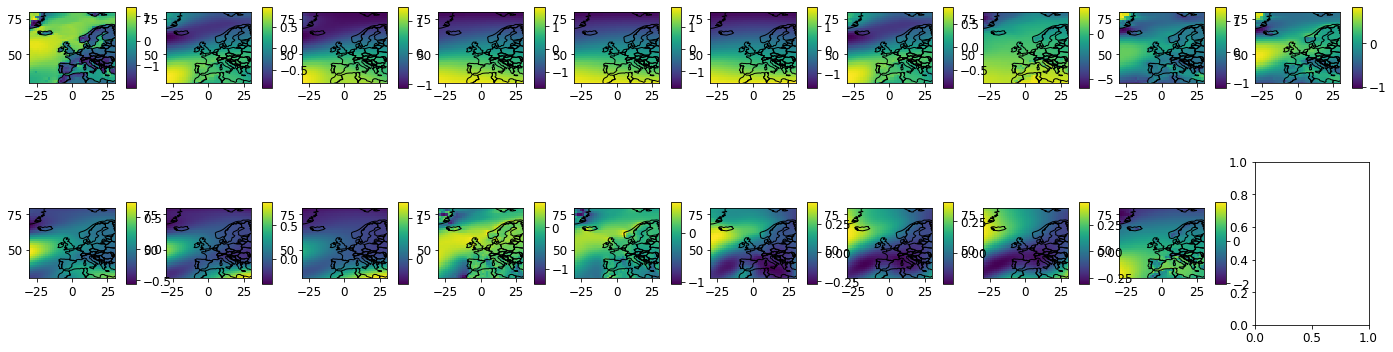

In [18]:
# Plotting the mean of the predictors
n_figs = len(dg_train.data[0,0,0,:])
ncols = 10
nrows = -(-n_figs // ncols)
fig, axes = plt.subplots(figsize=(24, 3.3*nrows), ncols=ncols, nrows=nrows)
for i in range(n_figs):
    i_row = i // ncols
    i_col = i % ncols
    ax = axes[i_row, i_col]
    vals = np.mean(dg_train.data[:,:,:,i], axis=0).to_numpy()
    plot_map(ax, lons_x, lats_y, vals, title=None)


In [19]:
fig.savefig('figures/input.png', bbox_inches=0, transparent='true')

In [20]:
# save the data

In [21]:
type(dstot_train)

xarray.core.dataset.Dataset

In [22]:
X,y=dg_train[0]

In [23]:
dstot_train.to_netcdf('data/dstot_train_daily.nc')
dstot_test.to_netcdf('data/dstot_test_daily.nc')

In [24]:
X, y= dg_train[0]

In [25]:
print(X.shape)
print(y.shape)

(32, 34, 41, 19)
(32, 34, 41, 19)


### Climatology and Persistence

In [26]:
# calculate persistence forecasts:Persistence simply means: Tomorrow's weather is today's weather.
def create_persistence_forecast(ds, lead_time, valid_time=True):
    assert lead_time > 0, 'Lead time must be greater than 0'
    X = ds.isel(time=slice(0, -lead_time))
    if valid_time:
        valid_time = ds.isel(time=slice(lead_time, None)).time
        X['time'] = valid_time 
    return X

In [27]:
max_leadtime = 7*6 # 42 days 1-6 weeks
lead_times = xr.DataArray(
    np.arange(1, max_leadtime + 1, 1), dims=['lead_time'], coords={'lead_time': np.arange(1, max_leadtime +1, 1)}, name='lead_time')

In [28]:
persistence = []
for l in lead_times:
    persistence.append(create_persistence_forecast(dstot_test, int(l)))
persistence = xr.concat(persistence, dim=lead_times)

In [29]:
persistence

,Array,Chunk
Bytes,1.99 GiB,48.52 MiB
Shape,"(42, 1825, 5, 34, 41)","(1, 1825, 5, 34, 41)"
Count,463 Tasks,42 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,407.60 MiB,9.70 MiB
Shape,"(42, 1825, 34, 41)","(1, 1825, 34, 41)"
Count,420 Tasks,42 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [30]:
# Save the predictions
persistence.to_netcdf(f'tmp/persistence.nc')

In [31]:
def create_climatology_forecast(ds_train):
    return ds_train.mean('time')

In [32]:
def create_weekly_climatology_forecast(ds_train, valid_time):
    ds_train['week'] = ds_train['time.week']
    weekly_averages = ds_train.groupby('week').mean('time')
    valid_time['week'] = valid_time['time.week']
    fc_list = []
    for t in valid_time:
        fc_list.append(weekly_averages.sel(week=t.week))
    return xr.concat(fc_list, dim=valid_time)

In [33]:
weekly_climatology = create_weekly_climatology_forecast(dstot_train, dstot_test.time)

/storage/homefs/no21h426/.conda/envs/cartopy/lib/python3.10/site-packages/xarray/core/accessor_dt.py:407: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/storage/homefs/no21h426/.conda/envs/cartopy/lib/python3.10/site-packages/xarray/core/accessor_dt.py:407: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(


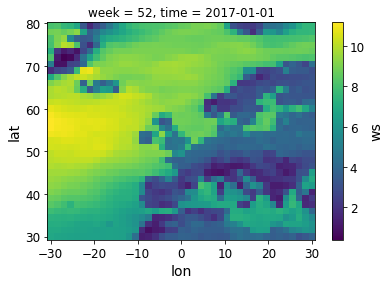

In [34]:
weekly_climatology.ws[0,:,:].plot()

In [35]:
weekly_climatology.to_netcdf(f'tmp/weekly_climatology.nc')

###  Simple UNET  without temporal component

In [36]:
#i2_shape = dg_train.datat.shape
i_shape = dg_train.data.shape[1:]
o_shape = dg_train.data.shape[1:]

In [37]:
print('inputs',i_shape)
print('output',o_shape)

inputs (34, 41, 19)
output (34, 41, 19)


In [38]:
# Computing the necessary output scaling.
dlons_x = float(lons_x[1] - lons_x[0])
dlats_x = float(lats_y[0] - lats_y[1])
dlons_y = float(lons_x[1] - lons_x[0])
dlats_y = float(lats_y[0] - lats_y[1])

output_scaling = int(dlons_x / dlons_y)
output_crop = None
output_channels = o_shape[2]

In [39]:
# model hyperparameters
output_scaling = 1
output_crop = None
EPOCHS = 50
#Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                            restore_best_weights=True)

# Default training options
opt_training = {'epochs': EPOCHS,
                'callbacks': [callback]}

In [40]:
loss='mse'
metric='mse'

In [41]:
# learning rates daily: unets:0.000003. resnet 0.00008
models = {
          'Unet': {'model': 'Unet', 'run': True,
                   'opt_model': {'output_scaling': output_scaling, 'output_crop': output_crop, 'unet_depth': 4, 'dropout_rate': 0.2, 'unet_use_upsample': False, 'bottleneck': False,  'for_extremes' : False},
                    'opt_optimizer': {'lr_method': 'Constant','lr':.000004}},
          'resnet': {'model': 'resnet', 'run': True,
                    'opt_model': {'for_extremes' : True, 'out_channels': output_channels},
                    'opt_optimizer': {'lr_method': 'Constant','lr':.000008}}}

In [42]:
plot_his = True

In [ ]:
l_mod = []
l_his = []
for m_id in models:


    # Clear session and set tf seed
    keras.backend.clear_session()
    tf.random.set_seed(42)

    if not models[m_id]['run']:
        continue
    # Extract model name and options
    model = models[m_id]['model']
    opt_model_i = models[m_id]['opt_model']
    opt_optimizer_i = models[m_id]['opt_optimizer']
    opt_model_new = opt_model_i.copy()
    opt_model_new.update(opt_model_i)
    opt_optimizer_new = opt_optimizer_i.copy()
    opt_optimizer_new.update(opt_optimizer_i)
    optimizer =  initiate_optimizer(dg_train, BATCH_SIZE, **opt_optimizer_new)
    
    if model == 'resnet':
        mod = build_res_unet(i_shape,  **opt_model_new)
    else:
        mod = Unet_Inputs(model, i_shape, o_shape, input_index=None, **opt_model_new)


    mod.compile(loss=loss, optimizer=optimizer,  metrics=metric)
    his_mod = mod.fit(dg_train, validation_data=dg_valid, **opt_training)
    
    if plot_his:
            pd.DataFrame(his_mod.history)[['loss','val_loss']].plot(figsize=(8,6), grid=True)
            plt.title('model' + model)

    # save models
    nam_mod = f'all_{model}.h5'
    if model == 'resnet':
        mod.save_weights(f'tmp/{nam_mod}')
    else:
        mod.model.save_weights(f'tmp/{nam_mod}')
   
    l_mod.append(mod)   
    l_his.append(his_mod)
    

2022-11-29 15:04:57.665881: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 15:04:58.117886: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9649 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3f:00.0, compute capability: 7.5


19
original design


2022-11-29 15:04:59.012006: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


Epoch 1/50
423/423 [==============================] - 26s 57ms/step - loss: 1.9222 - mse: 1.9222 - val_loss: 1.3847 - val_mse: 1.3847
Epoch 2/50
423/423 [==============================] - 22s 52ms/step - loss: 1.4988 - mse: 1.4988 - val_loss: 1.2291 - val_mse: 1.2291
Epoch 3/50
423/423 [==============================] - 22s 52ms/step - loss: 1.3604 - mse: 1.3604 - val_loss: 1.1605 - val_mse: 1.1605
Epoch 4/50
 39/423 [=>............................] - ETA: 19s - loss: 1.3360 - mse: 1.3360

In [44]:
l_his

In [52]:
# save his
all_his = []
n_models = [0, 1, 2]
for m_id,i in zip(models,n_models):
    # Clear session and set tf seed
    keras.backend.clear_session()
    tf.random.set_seed(42)
    if not models[m_id]['run']:
        continue
    # Extract model name and options
    model = models[m_id]['model']
    p = pd.DataFrame(l_his[i].history, columns=['loss', 'val_loss', 'mse','val_mse'])
    p['model'] = model
    all_his.append(p)

In [54]:
df_hist = pd.concat(all_his)
df_hist['epoch'] = df_hist.index

In [55]:
df_hist.to_csv('tmp/daily_all/df_all.csv')

#### Make predictions

In [56]:
preds_unet=create_predictions(l_mod[0].model, dg_test)

/storage/homefs/no21h426/Wind_S2S/utils/utils_predictions.py:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(dg)


In [57]:
preds_unet.to_netcdf('predictions/daily/preds_unet.nc')

In [74]:
preds_resnet =create_predictions(l_mod[1], dg_test)
preds_resnet.to_netcdf('predictions/daily/preds_resnet.nc')

In [60]:
rmse_unet = compute_weighted_rmse(preds_unet, dstot_test).load()
rmse_unetconv = compute_weighted_rmse(preds_unetconv, dstot_test).load()
rmse_resnet = compute_weighted_rmse(preds_resnet, dstot_test).load()

In [49]:
rmse_unet

<xarray.Dataset>
Dimensions:  ()
Data variables:
    ws       float64 2.828
    z        float64 127.0
    msl      float64 805.3
    t2m      float64 5.797
    u        float64 8.936
    v        float64 9.399

In [61]:
# If the model is trained using daily data, I will get iterative predictions for 8 weeks, otherwise -if train weekly- I will retreieve 16
preds_unet_int = create_iterative_predictions(l_mod[0].model , dg_test, max_lead_time= 7*6)
preds_unet_int.to_netcdf('predictions/daily/preds_unet_ite.nc')

115/115 [==============================] - 1s 11ms/step


In [75]:
preds_resnet_int = create_iterative_predictions(l_mod[1] , dg_test, max_lead_time= 7*6)
preds_resnet_int.to_netcdf('predictions/daily/preds_resnet_int.nc')

58/58 [==============================] - 0s 8ms/step
